In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pickle
from shapely.geometry import shape, Point
import rasterio.features
from osgeo import gdal, osr
from shapely.wkt import loads

import warnings
warnings.filterwarnings('ignore')

/Users/lizjohnson/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.0-CAPI-1.17.0). Conversions between both will be slow.
  warnings.warn(
/var/folders/9f/7xdrpjw15kn4wccwzb5xhr0m0000gn/T/ipykernel_18736/1062876411.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to S

# Step 1: Convert KDE Output from array to raster

In [2]:
# Import the KDE pickle file
with open('../Outputs/KDE_output_200m.pickle', 'rb') as f:
    kde_200 = pickle.load(f)

kde_200.shape

(9434, 8811)

In [3]:
kde_200.sum()

0.10990778711842207

In [4]:
#import brooklyn's boundary shape
bk_bndry = gpd.read_file('../Data/BrooklynBoundary.shp')
bk_bndry = bk_bndry.to_crs(32618)
bk_bndry.head()

,FID,geometry
0,0,"MULTIPOLYGON (((584478.960 4491458.524, 584470..."


In [5]:
#import tracts
nyc_tracts = pd.read_csv('../Data/2020_Census_Tracts_-_Tabular.csv')
nyc_tracts['the_geom'] = nyc_tracts['the_geom'].apply(loads)

# Convert the pandas DataFrame to a GeoDataFrame
tracts_gdf = gpd.GeoDataFrame(nyc_tracts, geometry='the_geom', crs = '4326')
tracts_gdf = tracts_gdf.to_crs(32618)
bk_tracts = tracts_gdf[tracts_gdf['BoroName'] == 'Brooklyn'].reset_index(drop = True)
bk_tracts.head()

,the_geom,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,Shape_Leng,Shape_Area
0,"MULTIPOLYGON (((585247.472 4506029.684, 585252...",1.00,3,Brooklyn,100,3000100,NaN,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000100,6611.443960,2.224101e+06
1,"MULTIPOLYGON (((584007.655 4500982.266, 583958...",2.00,3,Brooklyn,200,3000200,NaN,Sunset Park (West),BK0702,BK07,BK07 Sunset Park-Windsor Terrace (CD 7 Approxi...,36047000200,9075.285121,2.952085e+06
2,"MULTIPOLYGON (((584966.437 4505778.759, 584940...",3.01,3,Brooklyn,301,3000301,NaN,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000301,6525.111338,2.164337e+06
3,"MULTIPOLYGON (((585075.427 4505660.913, 585012...",5.01,3,Brooklyn,501,3000501,NaN,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000501,4828.170276,9.015070e+05
4,"MULTIPOLYGON (((585215.411 4505612.714, 585223...",5.02,3,Brooklyn,502,3000502,NaN,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000502,4902.479685,1.041529e+06


In [6]:
camera_locs = pd.read_csv('../Data/aggregated_camera_locs.csv',index_col = 0)
camera_locs['geometry'] = camera_locs['geometry'].apply(loads)
camera_locs = gpd.GeoDataFrame(camera_locs,geometry = 'geometry', crs = '4326')
camera_locs = camera_locs.to_crs(32618)
camera_locs['x'] = camera_locs.geometry.x
camera_locs['y'] = camera_locs.geometry.y
camera_locs.head()

,Data_Source,Camera_Count,geometry,x,y
0,Amnesty,5,POINT (588147.072 4505188.861),588147.071612,4.505189e+06
1,Amnesty,5,POINT (586867.513 4498122.217),586867.512967,4.498122e+06
2,Amnesty,1,POINT (587375.934 4506652.088),587375.933703,4.506652e+06
3,Amnesty,7,POINT (592666.168 4502926.211),592666.167996,4.502926e+06
4,Amnesty,1,POINT (587913.940 4503283.593),587913.939630,4.503284e+06


In [7]:
output_raster_path = '../Outputs/KDE_200m_raster_output.tif'

In [8]:
#convert to raster to use with geo shape files
# Define the minimum and maximum bounds of the raster
#change this to the bk boundary shapefile
min_x, min_y, max_x, max_y = bk_bndry.total_bounds

width = kde_200.shape[1]
height = kde_200.shape[0]
pixel_width = (max_x - min_x) / width
pixel_height = (max_y - min_y) / height
#define spatial reference
srs = osr.SpatialReference()
srs.ImportFromEPSG(32618) 
#create raster
driver = gdal.GetDriverByName('GTiff')
output_raster = driver.Create(output_raster_path, width, height, 1, gdal.GDT_Float32)

# Set the raster's geotransform (georeferencing information)
output_raster.SetGeoTransform((min_x, pixel_width, 0, max_y, 0, -pixel_height))

# Set the raster's spatial reference system (SRS)
if srs is not None:
    output_raster.SetProjection(srs.ExportToWkt())

# Write the array data to the raster
band = output_raster.GetRasterBand(1)
band.WriteArray(kde_200)

# Save and close the raster file
output_raster.FlushCache()
output_raster = None

In [9]:
x_grid, y_grid = np.meshgrid(np.linspace(min_x, max_x,width),
                             np.linspace(min_y, max_y, height))
levels = np.linspace(0, kde_200.max(), 25)

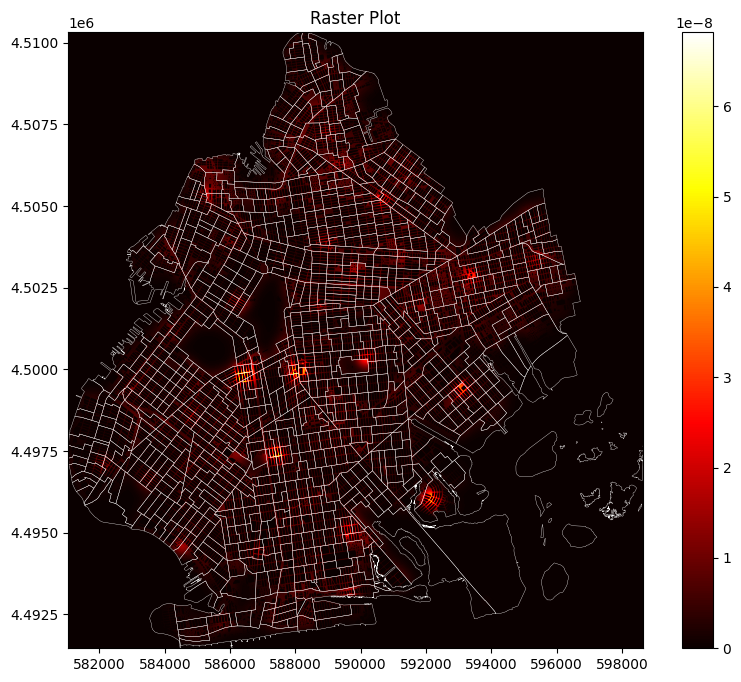

In [10]:
#check output
# Open the saved raster file
with rasterio.open(output_raster_path) as src:
    raster_array = src.read(1)

# Plot the raster array
fig, ax = plt.subplots(figsize=(10, 8))
raster_image = ax.imshow(raster_array, cmap='hot',extent=[min_x, max_x, min_y, max_y])
# Plot the bk_boundary geodataframe
bk_tracts.plot(ax=ax, facecolor='none', edgecolor='white',linewidth = 0.25)
fig.colorbar(raster_image, ax=ax)
ax.set_title('Raster Plot')
fig.savefig('../Outputs/raster_KDE200m_tracts_overlay.png',bbox_inches = 'tight')
plt.show()

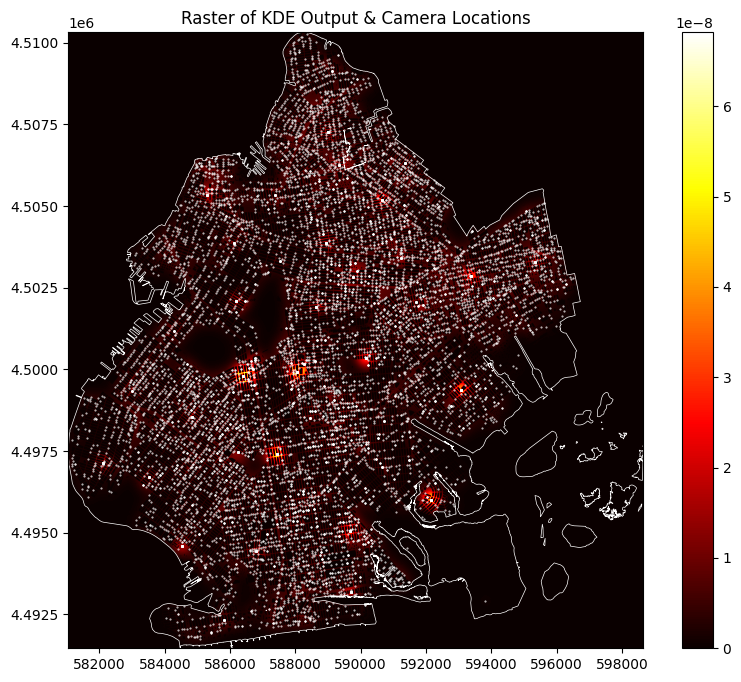

In [11]:
# Plot the raster array and camera points
fig, ax = plt.subplots(figsize=(10, 8))

raster_image = ax.imshow(raster_array, cmap='hot',extent=[min_x, max_x, min_y, max_y])
# Plot the bk_boundary geodataframe
camera_locs.plot(ax=ax,color='white',alpha = 0.8, markersize = 0.25)
bk_bndry.plot(ax=ax, facecolor='none', edgecolor='white',linewidth = 0.5)
fig.colorbar(raster_image, ax=ax)
ax.set_title('Raster of KDE Output & Camera Locations')
fig.savefig('../Outputs/raster_KDE200m_cameras_overlay.png',bbox_inches = 'tight')
plt.show()

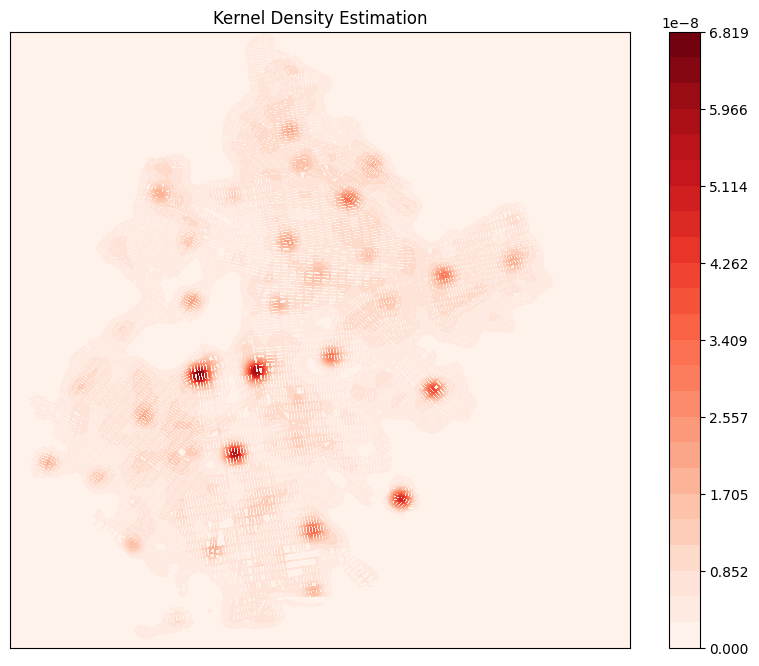

In [12]:
# Plot the array contour map
fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(x_grid, y_grid[::-1], kde_200, levels=levels, cmap=plt.cm.Reds)
# bk_tracts.plot(ax=ax, facecolor='none', edgecolor='black',linewidth = 0.25)
# Set title and color bar
ax.set_title('Kernel Density Estimation')
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(contour, ax=ax)

# Step 2: Sample random points from polygons to compute neighborhood surveillance load

In [13]:
from rasterio.mask import mask
from rasterio.plot import show
from shapely.geometry import mapping

In [14]:
# Load the raster file
raster = rasterio.open(output_raster_path)
type(raster)

rasterio.io.DatasetReader

In [15]:
def sample_points_within_geom(geometry, num_points):
    """
    Function to sample random points within each geometry of a geodataframe
    """
    bbox = tract_geometry.bounds
    min_x, min_y, max_x, max_y = bbox

    points = []
    while len(points) < num_points:
        # Generate random points within the bounding box of the tract
        random_x = np.random.uniform(min_x, max_x)
        random_y = np.random.uniform(min_y, max_y)
        point = (random_x, random_y)

        # Check if the random point falls within the tract
        if tract_geometry.contains(Point(point)):
            points.append(point)

    return points

In [17]:
num_points_per_tract = 10000  # Adjust the number of points per tract as needed
values_per_tract = []

for i, tract in bk_tracts.iterrows():
    tract_geometry = tract['the_geom']

    # Sample points within the current tract
    points = sample_points_within_geom(tract_geometry, num_points_per_tract)

    # Convert the points to a GeoDataFrame
    points_gdf = gpd.GeoDataFrame(geometry=[Point(p) for p in points])

    # Perform the raster masking to extract values at the points
    masked_data, _ = mask(raster, [mapping(tract_geometry)], crop=True)

    # Flatten the masked data to a 1D array
    values = masked_data.flatten()

    # Compute the average and standard deviation of the values
    avg_value = np.mean(values)
    std_dev_value = np.std(values)

    values_per_tract.append({'GEOID': tract['GEOID'],
                             'avg_value': avg_value,
                             'std_dev_value': std_dev_value})

In [18]:
from sklearn.preprocessing import StandardScaler

#Create a new GeoDataFrame from the results and join it with the original GeoDataFrame
results_df = pd.DataFrame(values_per_tract)
results_gdf = bk_tracts.merge(results_df, on='GEOID')

data = np.asarray(results_gdf['avg_value']).reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(data)
y_data = scaler.transform(data)
std_data = scaler.transform(np.asarray(results_gdf['std_dev_value']).reshape(-1, 1))

results_gdf['avg_value_scaled'] = y_data
results_gdf['std_dev_scaled'] = std_data
results_gdf.head(10)

,the_geom,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,Shape_Leng,Shape_Area,avg_value,std_dev_value,avg_value_scaled,std_dev_scaled
0,"MULTIPOLYGON (((585247.472 4506029.684, 585252...",1.00,3,Brooklyn,100,3000100,NaN,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000100,6611.443960,2.224101e+06,1.711508e-09,2.886487e-09,0.018722,0.976102
1,"MULTIPOLYGON (((584007.655 4500982.266, 583958...",2.00,3,Brooklyn,200,3000200,NaN,Sunset Park (West),BK0702,BK07,BK07 Sunset Park-Windsor Terrace (CD 7 Approxi...,36047000200,9075.285121,2.952085e+06,9.131503e-10,1.816372e-09,-0.631785,0.104166
2,"MULTIPOLYGON (((584966.437 4505778.759, 584940...",3.01,3,Brooklyn,301,3000301,NaN,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000301,6525.111338,2.164337e+06,9.005784e-10,1.460793e-09,-0.642028,-0.185562
3,"MULTIPOLYGON (((585075.427 4505660.913, 585012...",5.01,3,Brooklyn,501,3000501,NaN,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000501,4828.170276,9.015070e+05,7.750919e-10,2.257502e-09,-0.744276,0.463601
4,"MULTIPOLYGON (((585215.411 4505612.714, 585223...",5.02,3,Brooklyn,502,3000502,NaN,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000502,4902.479685,1.041529e+06,2.378376e-09,5.227909e-09,0.562090,2.883906
5,"MULTIPOLYGON (((584768.026 4505210.756, 584835...",7.00,3,Brooklyn,700,3000700,NaN,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000700,6253.288481,1.881578e+06,8.999012e-10,1.813893e-09,-0.642580,0.102145
6,"MULTIPOLYGON (((585277.844 4505341.993, 585297...",9.00,3,Brooklyn,900,3000900,NaN,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000900,5930.081771,1.769270e+06,2.138467e-09,4.355323e-09,0.366611,2.172918
7,"MULTIPOLYGON (((585744.080 4505382.481, 585742...",11.00,3,Brooklyn,1100,3001100,NaN,Downtown Brooklyn-DUMBO-Boerum Hill,BK0202,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047001100,5758.212823,1.811206e+06,4.908772e-09,6.620225e-09,2.623872,4.018373
8,"MULTIPOLYGON (((586132.291 4505671.315, 586141...",15.01,3,Brooklyn,1501,3001501,NaN,Downtown Brooklyn-DUMBO-Boerum Hill,BK0202,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047001501,6693.224944,1.776325e+06,2.424235e-09,3.091633e-09,0.599456,1.143256
9,"MULTIPOLYGON (((585968.114 4505243.128, 585968...",15.02,3,Brooklyn,1502,3001502,NaN,Downtown Brooklyn-DUMBO-Boerum Hill,BK0202,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047001502,5512.190989,1.520131e+06,3.378263e-09,4.186449e-09,1.376804,2.035319


<Axes: >

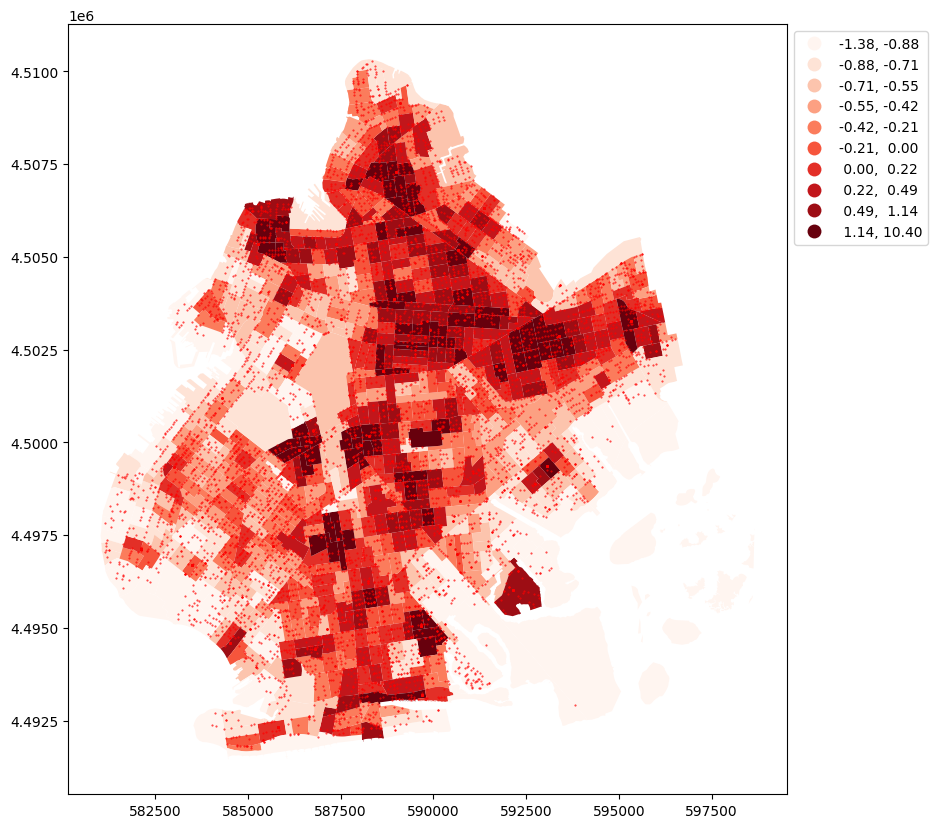

In [37]:
fig, ax = plt.subplots(figsize = (10,10))
results_gdf.plot(column = 'avg_value_scaled',ax = ax,cmap='Reds', legend = True,k = 10, scheme = 'Quantiles',
                missing_kwds={"color": "lightgrey", ## what to do with missing values
                                 "edgecolor": "red",
                                 "hatch": "///",
                                 "label": "Missing values",}
             ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})
camera_locs.plot(ax=ax,color='red',alpha = 0.8, markersize = 0.25)

In [31]:
bk_blks = gpd.read_file('../Data/BrooklynBlocks/BrooklynBlocks.shp')
bk_tracts = gpd.read_file('../Data/BrooklynTracts/BrooklynTracts.shp')
bk_bg = gpd.read_file('../Data/BrooklynBlockGroups/BrooklynBlockGroups.shp')
bk_nta = gpd.read_file('../Data/BrooklynNTAs/BrooklynNTAs.shp')

In [32]:
#change crs from 4326 to 
bk_blks = bk_blks.to_crs(32618)
bk_tracts = bk_tracts.to_crs(32618)
bk_bg = bk_bg.to_crs(32618)
bk_nta = bk_nta.to_crs(32618)

In [40]:
#check the columns of each dataframe so we can standardize
bk_blks.head()

,CB2020,BoroCode,BoroName,CT2020,BCTCB2020,GEOID,Shape_Leng,Shape_Area,geometry
0,1,3,Brooklyn,1801,30018010001,360470018010001,1061.915908,14961.031969,"MULTIPOLYGON (((584592.064 4502419.952, 584591..."
1,1,3,Brooklyn,1803,30018030001,360470018030001,4053.894954,83041.203647,"MULTIPOLYGON (((582738.379 4500475.968, 582748..."
2,1,3,Brooklyn,1804,30018040001,360470018040001,653.460985,3891.785188,"MULTIPOLYGON (((582168.929 4499738.822, 582146..."
3,1,3,Brooklyn,3400,30034000001,360470034000001,1292.527355,35171.987124,"POLYGON ((581453.732 4499145.540, 581447.007 4..."
4,1,3,Brooklyn,5301,30053010001,360470053010001,563.499018,6125.607515,"MULTIPOLYGON (((583014.760 4503038.093, 583010..."


In [41]:
bk_tracts.head()

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,Shape_Leng,Shape_Area,geometry
0,1.00,3,Brooklyn,100,3000100,None,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000100,6611.443960,2.224101e+06,"POLYGON ((585247.472 4506029.684, 585252.447 4..."
1,2.00,3,Brooklyn,200,3000200,None,Sunset Park (West),BK0702,BK07,BK07 Sunset Park-Windsor Terrace (CD 7 Approxi...,36047000200,9075.285121,2.952085e+06,"POLYGON ((584007.655 4500982.266, 583958.881 4..."
2,3.01,3,Brooklyn,301,3000301,None,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000301,6525.111338,2.164337e+06,"POLYGON ((584966.437 4505778.759, 584940.848 4..."
3,5.01,3,Brooklyn,501,3000501,None,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000501,4828.170276,9.015070e+05,"POLYGON ((585075.427 4505660.913, 585012.652 4..."
4,5.02,3,Brooklyn,502,3000502,None,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000502,4902.479685,1.041529e+06,"POLYGON ((585215.411 4505612.714, 585223.049 4..."


In [42]:
bk_bg.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,36,047,101200,1,360471012001,Block Group 1,G5030,S,80394,0,+40.6405425,-073.8945760,"POLYGON ((593266.299 4499421.090, 593339.922 4..."
1,36,047,101800,1,360471018001,Block Group 1,G5030,S,283765,0,+40.6438530,-073.8866450,"POLYGON ((593739.771 4500498.638, 593883.226 4..."
2,36,047,109800,1,360471098001,Block Group 1,G5030,S,266969,0,+40.6545238,-073.8975990,"POLYGON ((592977.020 4501007.097, 593042.260 4..."
3,36,047,077000,1,360470770001,Block Group 1,G5030,S,45845,0,+40.6347960,-073.9511877,"POLYGON ((588600.518 4498872.124, 588650.999 4..."
4,36,047,077200,1,360470772001,Block Group 1,G5030,S,124696,0,+40.6339173,-073.9541894,"POLYGON ((588264.268 4498819.944, 588342.444 4..."


In [43]:
bk_nta.head()

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry
0,3.0,Brooklyn,047,BK40,Windsor Terrace,1.404167e+07,19033.672066,"POLYGON ((586207.563 4501643.060, 586204.695 4..."
1,3.0,Brooklyn,047,BK50,Canarsie,8.208968e+07,43703.609666,"MULTIPOLYGON (((593990.695 4500133.738, 593989..."
2,3.0,Brooklyn,047,BK68,Fort Greene,1.648282e+07,19825.520859,"POLYGON ((587073.122 4505530.649, 587074.580 4..."
3,3.0,Brooklyn,047,BK79,Ocean Hill,2.008991e+07,22494.581245,"POLYGON ((592689.215 4503673.539, 592744.085 4..."
4,3.0,Brooklyn,047,BK44,Madison,2.737916e+07,26237.257649,"POLYGON ((589882.064 4495847.157, 589818.490 4..."


In [119]:
import json
from shapely.geometry import Polygon

# List to store the results
gdfs = [bk_blks, bk_tracts, bk_bg, bk_nta]
all_results = []

for gdf in gdfs:
    # Perform the sampling and analysis as described in the previous code

    num_points = 10000  # Adjust the number of points per tract as needed
    values_per_geom = []

    if gdf is bk_nta:
        id_col = 'ntacode'
    else:
        id_col = 'GEOID'

    for i, row in gdf.iterrows():
        geom = row['geometry']

        # Sample points within the current tract
        points = sample_points_within_geom(geom, num_points)

        # Convert the points to a GeoDataFrame
        points_gdf = gpd.GeoDataFrame(geometry=[Point(p) for p in points])

        # Perform the raster masking to extract values at the points
        masked_data, _ = mask(raster, [mapping(geom)], crop=True)

        # Flatten the masked data to a 1D array
        values = masked_data.flatten()

        # Compute the average and standard deviation of the values
        avg_value = np.mean(values)
        std_dev_value = np.std(values)

        values_per_geom.append({id_col: row[id_col],
                                'avg_value': avg_value,
                                'std_dev_value': std_dev_value})

    # Create a new GeoDataFrame from the results and join it with the original GeoDataFrame
    results_df = pd.DataFrame(values_per_geom)
    results_gdf = gdf.merge(results_df, on=id_col)

    data = np.asarray(results_gdf['avg_value']).reshape(-1, 1)
    scaler = StandardScaler()
    scaler.fit(data)
    y_data = scaler.transform(data)
    std_data = scaler.transform(np.asarray(results_gdf['std_dev_value']).reshape(-1, 1))

    results_gdf['avg_value_scaled'] = y_data
    results_gdf['std_dev_scaled'] = std_data

    rows = []

    # Iterate over each row in the GeoDataFrame
    for index, row in results_gdf.iterrows():
        # Create a dictionary for the current row
        row_dict = {
            'geojson': row.geometry.__geo_interface__,
            'results': row.drop('geometry').to_dict()
        }
        # Append the row dictionary to the list
        rows.append(row_dict)

    # Append the results to the list
    all_results.append(rows)

# Save the results to a JSON file
output_file = '../Outputs/KDE_sampling.json'
with open(output_file, 'w') as f:
    json.dump(all_results, f, indent=4)

In [120]:
# Open and read the JSON file
with open(output_file, 'r') as f:
    data = json.load(f)

print(type(data),len(data))

<class 'list'> 4


In [122]:
features = []
for item in data[3]:
    geometry = shape(item['geojson'])
    properties = item['results']
    features.append({"geometry": geometry, "properties": properties})

nta_surv = gpd.GeoDataFrame.from_features(features)
nta_surv.head()

,geometry,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,avg_value,std_dev_value,avg_value_scaled,std_dev_scaled
0,"POLYGON ((586207.563 4501643.060, 586204.695 4...",3.0,Brooklyn,047,BK40,Windsor Terrace,1.404167e+07,19033.672066,1.448168e-09,4.911048e-09,0.002737,5.734309
1,"MULTIPOLYGON (((593990.695 4500133.738, 593989...",3.0,Brooklyn,047,BK50,Canarsie,8.208968e+07,43703.609666,1.281708e-09,3.158630e-09,-0.272779,2.833801
2,"POLYGON ((587073.122 4505530.649, 587074.580 4...",3.0,Brooklyn,047,BK68,Fort Greene,1.648282e+07,19825.520859,1.760309e-09,2.488851e-09,0.519377,1.725220
3,"POLYGON ((592689.215 4503673.539, 592744.085 4...",3.0,Brooklyn,047,BK79,Ocean Hill,2.008991e+07,22494.581245,1.693840e-09,3.410619e-09,0.409361,3.250880
4,"POLYGON ((589882.064 4495847.157, 589818.490 4...",3.0,Brooklyn,047,BK44,Madison,2.737916e+07,26237.257649,1.875211e-09,4.399424e-09,0.709556,4.887497


<Axes: >

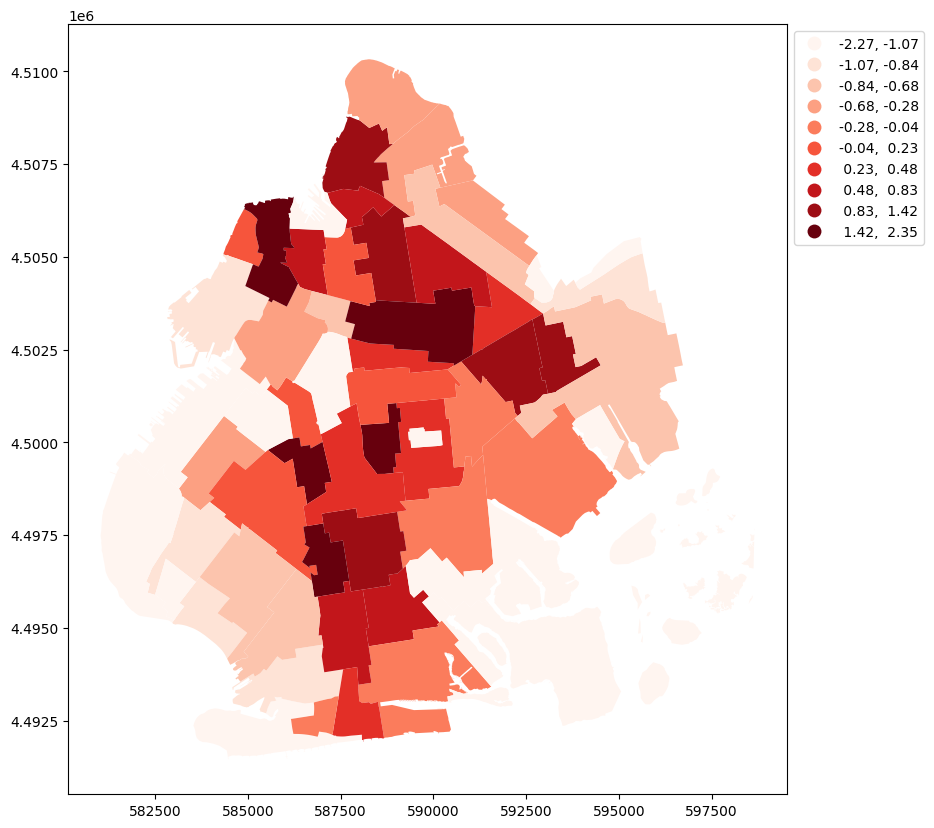

In [123]:
fig, ax = plt.subplots(figsize = (10,10))
nta_surv.plot(column = 'avg_value_scaled',ax = ax,cmap='Reds', legend = True,k = 10, scheme = 'Quantiles',
                missing_kwds={"color": "lightgrey", ## what to do with missing values
                                 "edgecolor": "red",
                                 "hatch": "///",
                                 "label": "Missing values",}
             ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})